In [5]:
# === Header ===
#
# @date: 05 / 07 / 2019 (Xi'an)
# @author: ZHE LI
# @title: Learned KD-Tree - Fully Learned
#
import math
import time
import random
#import pysnooper
import statistics
import numpy as np
from scipy import stats
from numpy import genfromtxt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn import preprocessing
from sklearn.preprocessing import normalize

In [ ]:
# === Data Loading ===
original_domains = [\
    [1,1.20000000e+07],\
    [1,4.00000000e+05],\
    [1,2.00000000e+04],\
    [1,7.00000000e+00],\
    [1,5.00000000e+01],\
    [900.99,1.04899500e+05],\
    [0,1.00000000e-01],\
    [0,8.00000000e-02]\
]
original_domains = np.asarray(original_domains)
original_dataset = genfromtxt('/Users/lizhe/Desktop/LearnedKDTree/DataAndWorkload/SyntheticData/TPCH_12M_8Field.csv', delimiter=',')

In [ ]:
# === Global Configuration ===

# dimension for query and build learned KD-Tree
used_dimensions = [1,2]

# testing set percentage
testing_set_percentage = 0.2

# percentage of each dimension
percentage_ = [1, 1]

# maximum expected ranges
ranges_ = [10000, 500]

# maximum expected sigma
sigmas_ = [1000, 50]

# clusters amount
cluster_amount_ = 100

# queries in each cluster
queries_each_cluster_ = 10

# page block size
block_size = 32000

domains_ = np.copy(original_domains)
domains_ = domains_[used_dimensions]
dataset = np.copy(original_dataset)
dataset = dataset[:,used_dimensions]

In [ ]:
# # measure the differnet calculation method of median index
# np.random.shuffle(dataset)

# # === calculated by sorting ===
# start_time = time.time()
# total_size = len(dataset)
# dataset = dataset[dataset[:, 1].argsort()]
# median = dataset[int(total_size / 2), 1]
# end_time = time.time()
# print("find median by sorting(s): ", end_time-start_time)
# print("median: ", median)

# np.random.shuffle(dataset)

# start_time = time.time()
# mid = np.median(dataset[:,1])
# end_time = time.time()
# print("find median by fast median(s): ", end_time-start_time)
# print("median: ", mid)

In [ ]:
# print('variance for the first query dimension: ',np.var(dataset[:,0]))
# print('variance for the second query dimension: ',np.var(dataset[:,1]))
# print('variance for the third query dimension: ',np.var(dataset[:,2]))

In [ ]:
# Try to improve query generation:
# 1. the number of queries in each cluster should be random (under a maximum number, maybe under zipfian distribution)
# 2. the number of clusters should be random (under a maximum number)

In [ ]:
# === Query Generation ===
#
# by default, use Gaussian distribution to generate the synthetic query workload
#
# @cluster_amount: the cluster amount of the query; integer
# @queries_in_each_cluster: the number of queries in each cluster; interger
# @dimensions: the domain of each dimension; numpy object
# @maximum_expected_range: the maximum expected range of each dimension; array object
# @maximum_sigma: the maximum sigma of Gaussian distribution of each dimension; array object
#
# return @temp_queries: array object
#
def generate_query_clustered(cluster_amount, queries_in_each_cluster, dimensions, maximum_expected_range, maximum_sigma, percentage):
    random.seed()
    num_dims = len(dimensions)
    
    queries = []
    for j in range(num_dims):
        queries.append([])
    
    # for each cluster
    for i in range(cluster_amount):
        
        # determin the cluster center on each dimension
        cluster_center = []
        
        # for each dimension
        for j in range(num_dims):
            
            # to assure the distribution do not exceed the border
            dim_range = dimensions[j][1]-dimensions[j][0]
            center1D = random.randrange(dim_range)
            cluster_center.append(center1D)
            
            query_range = random.randrange(maximum_expected_range[j])
            range_lower = center1D - query_range/2
            range_upper = center1D + query_range/2
            
            if range_lower <= dimensions[j][0]:
                range_lower = dimensions[j][0]
            if range_upper >= dimensions[j][1]:
                range_upper = dimensions[j][1]
            
            sigma = random.randrange(maximum_sigma[j])
            
            # for each query
            for k in range(queries_in_each_cluster):
                
                # determine if to let this query dimension invalid by percentage (i.e., cover the entire domain)
                possibility = random.uniform(0, 1)
                if possibility > percentage[j]:
                    lower1D = dimensions[j][0]
                    upper1D = dimensions[j][1]
                    queries[j].append([lower1D, upper1D])
                else:
                    #determin the lower bound
                    lower1D = random.gauss(range_lower, sigma)
                    upper1D = random.gauss(range_upper, sigma)
                    if lower1D <= dimensions[j][0]:
                        lower1D = dimensions[j][0]
                    if lower1D >= dimensions[j][1]:
                        lower1D = dimensions[j][1]
                    if upper1D <= dimensions[j][0]:
                        upper1D = dimensions[j][0]
                    if upper1D >= dimensions[j][1]:
                        upper1D = dimensions[j][1]
                    if lower1D > upper1D:
                        lower1D, upper1D = upper1D, lower1D
                    queries[j].append([lower1D, upper1D])
                
    # transform the query structure
    temp_queries = []
    values = []
    for i in range(len(queries[0])):
        for j in range(num_dims):
            values.append(queries[j][i])
        temp_queries.append(values)
        values=[]
            
    # return queries
    return temp_queries

In [ ]:
# Example of usage (Generate Query)

#@pysnooper.snoop()
def query_seperation(query_collection, training_set_percentage = 0.8):
    np.random.shuffle(query_collection)
    training_set_size = int(training_set_percentage * len(query_collection))
    query_collection = np.asarray(query_collection) # as the shuffle make np to array, we need to make it back
    training_set = query_collection[0:training_set_size,:]
    testing_set = query_collection[training_set_size:-1,:]
    return training_set, testing_set

query_collection = generate_query_clustered(cluster_amount_, queries_each_cluster_, domains_, ranges_, sigmas_, percentage_)

training_set, testing_set = query_seperation(query_collection, 1-testing_set_percentage)
# training_set = query_collection
# testing_set = query_collection

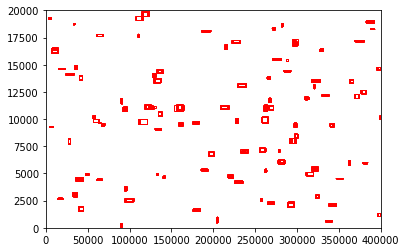

In [7]:
# === Query Visualization ===
#
# plot the queries, only in 2D
#
# @query_collection: could be more than 2 dimensions, but only plot the first 2 dimensions
# @domains: the domain of the plot dimensions, shoud be corresponding with the order of plotdim
#
def plot_queries_2d(query_collection, domains):
    
    fig, ax = plt.subplots(1)
    
    plt.xlim(domains[0][0],domains[0][1])
    plt.ylim(domains[1][0],domains[1][1])
    
    # transform the queries into boxes
    query_size = len(query_collection)
    # the number of boxed that will be plotted
    boxes = []
    for i in range(query_size):
        lower1 = query_collection[i][0][0]
        upper1 = query_collection[i][0][1]
        lower2 = query_collection[i][1][0]
        upper2 = query_collection[i][1][1]
        rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='r',linewidth=1)
        ax.add_patch(rect)
    
    plt.show()

plot_queries_2d(query_collection, domains_)

In [ ]:
# === Assistant Functions ===
#
# this works for one dimension only !!! An implementation of query bounding.

def getoverlap(al, au, bl, bu):
    return max(0, min(au,bu)-max(al,bl))

# currently not used.
def bounding_union(query_collection):
    
    # should keep it ordered first by the lower interval !!!!!!
    query_collection = query_collection[query_collection[:,0].argsort()]
    
    remaining_query = query_collection
    bounded_intervals = []
    
    while len(remaining_query) != 0:
        
        initial_interval = [remaining_query[0][0], remaining_query[0][1]]
        temp_interval = []
        
        for i in range(len(remaining_query)-1):
            
            overlap = getoverlap(initial_interval[0],initial_interval[1],remaining_query[i+1][0], remaining_query[i+1][1])
            
            # there is no overlap
            if overlap == 0:
                temp_interval.append([remaining_query[i+1][0], remaining_query[i+1][1]])
            else: # update interval border
                initial_interval[0] = min(initial_interval[0], remaining_query[i+1][0])
                initial_interval[1] = max(initial_interval[1], remaining_query[i+1][1])
                
        bounded_intervals.append(initial_interval)
        remaining_query = temp_interval
    
    return bounded_intervals

In [893]:
# === Learned KD-Tree Split ===
#
# asssumption: the query boundings will not overlap. divide the KD-Tree recursively
#
# @dataset: contains the data only in this subnode, ordered in original load order;
# @query: contains all the queries (bounded or original); ordered in original generated order;
# @domains: the current domain of the node of every dimension [first lower, second upper],[]...; array object
# @threshold: maximum page size
# @level: the current tree depth
#
# return @kdnodes: contains the domain of each node and the correpsonding records amount, notice the domain is
# ordered by the original load order as dataset

def LearnedResuriveDivide(dataset, query, domains, threshold, level, current_dim = 0):
    # print("level: ",level)
    # print("dataset size: ",len(dataset))

    # check if the threshold is already satisfied
    total_size = len(dataset)
    if total_size <= threshold:
        # the kdnodes should be an global object outside the function
        kdnodes = []
        kdnodes.append([domains, total_size])
        return kdnodes

    split_distance_each_dim = []
    split_position_each_dim = []
    split_value_each_dim = []
    # for each dimension, we calculated the distance from median to its first non-cross split
    for D in range(len(dataset[0])):

        # sort the dataset in this dimension
        dataset = dataset[dataset[:, D].argsort()]

        # median
        median = dataset[int(total_size / 2), D]
        median_low = domains[D][0]
        median_up = domains[D][1]

        # split position
        split_distance = 0
        split_position = int(total_size / 2)
        split_low = 0
        split_up = total_size

        # that is the place where we need query bounding !
        if len(query) == 0:
            split_distance_each_dim.append(split_distance)
            split_position_each_dim.append(split_position)
            split_value_each_dim.append(median)
            continue

        query = np.asarray(query)
        query_in_this_dim = query[:, D]

        # generate bounded intervals in this dim
        query_in_this_dim = query_in_this_dim[query_in_this_dim[:, 0].argsort()]
        remaining_query = query_in_this_dim
        bounded_intervals = []

        while len(remaining_query) != 0:

            initial_interval = [remaining_query[0][0], remaining_query[0][1]]
            temp_interval = []

            for i in range(len(remaining_query) - 1):

                overlap = getoverlap(initial_interval[0], initial_interval[1], remaining_query[i + 1][0],
                                     remaining_query[i + 1][1])
                # there is no overlap
                if overlap == 0:
                    temp_interval.append([remaining_query[i + 1][0], remaining_query[i + 1][1]])
                else:  # update interval border
                    initial_interval[0] = min(initial_interval[0], remaining_query[i + 1][0])
                    initial_interval[1] = max(initial_interval[1], remaining_query[i + 1][1])

            bounded_intervals.append(initial_interval)
            remaining_query = temp_interval
        query_bound = bounded_intervals
        
        # check if the split position intersect some query boundings in this dim
        for i in range(len(query_bound)):

            # if intersect some query bounds
            if median > query_bound[i][0] and median < query_bound[i][1]:

                # check if the two end already exceeds domain
                if query_bound[i][0] < domains[D][0] and query_bound[i][1] > domains[D][1]:
                    split_distance = int(total_size / 2)
                    break;

                # if not exceeds, determine which side is closer to the median
                else:
                    if query_bound[i][0] >= domains[D][0]:
                        # get the number of records from median to the end
                        for j in range(split_position - 1, -1, -1):
                            if dataset[j][D] <= query_bound[i][0]:
                                split_low = j
                                median_low = dataset[split_low, D]
                                break

                    if query_bound[i][1] <= domains[D][1]:
                        # get the number of records from median to the end
                        for j in range(split_position, total_size, 1):
                            if dataset[j][D] >= query_bound[i][1]:
                                split_up = j
                                median_up = dataset[split_up, D]
                                break

                # if not exceeds then choose the one that is closest from the median (in terms of #records!)
                if (total_size / 2) - split_low < (split_up - total_size / 2) and split_low != 0:
                    split_position = split_low
                    median = median_low
                    split_distance = int(total_size / 2) - split_position
                elif (total_size / 2) - split_low >= (split_up - total_size / 2) and split_up != total_size:
                    split_position = split_up
                    median = median_up
                    split_distance = split_position - int(total_size / 2)

        split_distance_each_dim.append(split_distance)
        split_position_each_dim.append(split_position)
        split_value_each_dim.append(median)

    # aftern calculating the distance from median to its first non-cross split

    split_distance_each_dim = np.asarray(split_distance_each_dim)
    
    split_dimension = 0
    split_position = int(total_size / 2)
    split_value = 0
    
    # degradation mechansim (if no valid split position, then using round robin)
    # if the median do not cross any historical query, split round robin to enhance robustness
    if min(split_distance_each_dim) == int(total_size / 2) or max(split_distance_each_dim) == 0:
        # using variance is not good
#         dim_variance = []
#         for D in range(len(dataset[0])):
#            dim_variance.append(np.var(dataset[:,D]))
#         split_dimension = np.argmax(dim_variance)
#         #split_dimension = random.randrange(len(dataset[0])) # using random is not good
#         split_position = int(total_size / 2)
#         dataset = dataset[dataset[:, split_dimension].argsort()]
#         split_value = dataset[split_position, split_dimension]
        split_dimension = current_dim + 1
        if split_dimension >= len(domains):
            split_dimension %= len(domains)
        split_position = int(total_size / 2)
        dataset = dataset[dataset[:, split_dimension].argsort()]
        split_value = dataset[split_position, split_dimension]
    else:
        split_dimension = np.argmin(split_distance_each_dim)  # get the split dimension
        #print("level: ",level," split_dimension: ",  split_dimension, " split_distances: ", split_distance_each_dim)
        # split_dimension =  split_distance_each_dim.argsort()[0] # get the split dimension
        dataset = dataset[dataset[:, split_dimension].argsort()]
        split_position = split_position_each_dim[split_dimension]  # get the split position
        split_value = split_value_each_dim[split_dimension]

    # split the dataset according to the split position
    sub_dataset1 = dataset[0:split_position, :]
    sub_dataset2 = dataset[split_position:-1, :]

    # change the domains
    sub_domains1 = np.copy(domains)
    sub_domains1[split_dimension][1] = split_value
    sub_domains2 = np.copy(domains)
    sub_domains2[split_dimension][0] = split_value

    # filter the queries for each sub node
    sub_query1 = []
    sub_query2 = []
    for i in range(len(query)):
        if query[i][split_dimension][0] < split_value:
            sub_query1.append(query[i])
        if query[i][split_dimension][1] > split_value:
            sub_query2.append(query[i])

    # used to see the current depth
    level += 1

    # recursion
    kdnodes = []
    kdnodes.extend(LearnedResuriveDivide(sub_dataset1, sub_query1, sub_domains1, threshold, level, split_dimension))
    kdnodes.extend(LearnedResuriveDivide(sub_dataset2, sub_query2, sub_domains2, threshold, level, split_dimension))

    return kdnodes

start_time = time.time()
kdnodes = LearnedResuriveDivide(dataset, training_set, domains_, block_size, 0)
end_time = time.time()
print("training time for Learned KD-Tree(s): ", end_time-start_time)
print('learned KD-Tree leaf nodes: ',len(kdnodes))

training time for Learned KD-Tree(s):  33.436580657958984
learned KD-Tree leaf nodes:  512


In [922]:
# === Learned KD-Tree Split (Fast Version) ===
#
# asssumption: the query boundings will not overlap. divide the KD-Tree recursively
#
# @dataset: contains the data only in this subnode, ordered in original load order;
# @query: contains all the queries (bounded or original); ordered in original generated order;
# @domains: the current domain of the node of every dimension [first lower, second upper],[]...; array object
# @threshold: maximum page size
# @level: the current tree depth
#
# return @kdnodes: contains the domain of each node and the correpsonding records amount, notice the domain is
# ordered by the original load order as dataset
def FastLearnedResuriveDivide(dataset, query, domains, threshold, level, current_dim = 0):

    # check if the threshold is already satisfied
    total_size = len(dataset)
    if total_size <= threshold:
        kdnodes = []
        kdnodes.append([domains, total_size])
        return kdnodes
    
    split_distance_each_dim = []
    split_position_each_dim = []
    split_value_each_dim = []
    
    # for each dimension, we calculated the distance from median to its first non-cross split
    for D in range(len(dataset[0])):

        # median, with fast median algorithm
        median = np.median(dataset[:,D])
        median_low = domains[D][0]
        median_up = domains[D][1]    

        # split position
        split_distance = 0
        split_position = int(total_size / 2)

        # that is the place where we need query bounding !
        if len(query) == 0:
            split_distance_each_dim.append(split_distance)
            split_position_each_dim.append(split_position)
            split_value_each_dim.append(median)
            continue

        query = np.asarray(query)
        query_in_this_dim = query[:, D]
        
        # bound the projected queries in this dimension
        query_bound = bounding_union(query_in_this_dim)
        
        # check if the split position intersect some query boundings in this dim
        for i in range(len(query_bound)):

            # if intersect some query bounds (only possible to intersect one bounded query)
            if median > query_bound[i][0] and median < query_bound[i][1]:

                # check if the two end already exceeds domain, if yes, split from the middle
                if query_bound[i][0] <= domains[D][0] and query_bound[i][1] >= domains[D][1]:
                    split_distance = int(total_size / 2)
                    break;
                # if not exceeds, determine which side is closer to the median
                else:
                    # for the left side
                    if query_bound[i][0] > domains[D][0]:
                        median_low = query_bound[i][0]         
                    # for the right side
                    if query_bound[i][1] < domains[D][1]:
                        median_up = query_bound[i][1]

                # if not exceeds then choose the one that is closest from the median (in terms of #records!)
                number_of_records_from_low_to_median = len(dataset[(dataset[:,D]>=median_low) & (dataset[:,D] < median)])
                number_of_records_from_up_to_median = len(dataset[(dataset[:,D]<=median_up) & (dataset[:,D] > median)])
                
                if number_of_records_from_low_to_median <= number_of_records_from_up_to_median:
                    median = median_low
                    split_distance = number_of_records_from_low_to_median
                else:
                    median = median_up
                    split_distance = number_of_records_from_up_to_median
                    
        # for each dimension, record its result
        split_distance_each_dim.append(split_distance)
        split_value_each_dim.append(median)

    # aftern calculating the distance from median to its first non-cross split
    split_distance_each_dim = np.asarray(split_distance_each_dim)
    split_dimension = 0
    split_value = 0
    
    # degradation mechansim (if no valid split position, then using round robin)
    # if the median do not cross any historical query, split round robin to enhance robustness
    if min(split_distance_each_dim) >= int((total_size / 2)-10) or max(split_distance_each_dim) <= 10:
        split_dimension = current_dim + 1
        if split_dimension >= len(domains):
            split_dimension %= len(domains)
        split_value = np.median(dataset[:,split_dimension])
    else:
        split_dimension = np.argmin(split_distance_each_dim)  # get the split dimension
        split_value = split_value_each_dim[split_dimension]

    # split the dataset according to the split position
    sub_dataset1 = dataset[dataset[:,split_dimension] <= split_value]
    sub_dataset2 = dataset[dataset[:,split_dimension] > split_value]

    # change the domains
    sub_domains1 = np.copy(domains)
    sub_domains1[split_dimension][1] = split_value
    sub_domains2 = np.copy(domains)
    sub_domains2[split_dimension][0] = split_value

    # filter the queries for each sub node
    sub_query1 = query[query[:,split_dimension,0] < split_value]
    sub_query2 = query[query[:,split_dimension,1] > split_value]

    # used to see the current depth
    level += 1

    # recursion
    kdnodes = []
    kdnodes.extend(FastLearnedResuriveDivide(sub_dataset1, sub_query1, sub_domains1, threshold, level, split_dimension))
    kdnodes.extend(FastLearnedResuriveDivide(sub_dataset2, sub_query2, sub_domains2, threshold, level, split_dimension))

    return kdnodes

start_time = time.time()
fast_kdnodes = FastLearnedResuriveDivide(dataset, training_set, domains_, block_size, 0)
end_time = time.time()
print("training time for fast Learned KD-Tree(s): ", end_time-start_time)
print('fast learned KD-Tree leaf nodes: ',len(fast_kdnodes))

training time for fast Learned KD-Tree(s):  9.001773834228516
fast learned KD-Tree leaf nodes:  513


In [813]:
# === Performance Evaluation ===
#
# evaluate the blocks of data to be fetched, when physical data of kdnodes are seperate !!!
# @queries: a collection of queries contains the lower and upper value in all dimensions; numpy object
# @kdnodes: the kdnodes generated above; array object

def Query(queries, kdnodes):
    
    counts = []
    count_single_query = 0;
    
    # number of dimensions
    dims = int(len(queries[0]))
    
    # for each query
    for i in range(len(queries)):
        
        count_single_query = 0
        
        # check for intersection for each kdnode
        for j in range(len(kdnodes)):
            
            # for each dimension
            intersection_tag = True
            for k in range(dims):
                
                # an intersection holds if it intersecs in all dimensions
                if queries[i][k][0] >= kdnodes[j][0][k][1] or queries[i][k][1] <= kdnodes[j][0][k][0]:
                    intersection_tag = False
                    break
                
            # if the query intersect with this kdnode
            if intersection_tag:
                count_single_query += 1
            
        counts.append(count_single_query)
    
    #print("blocks IO: ", counts)
    print("blocks IO(average): ", statistics.mean(counts))

# === Performance Evaluation (dense) ===
#
# evaluate the blocks of data to be fetched, when physical data of kdnodes are dense !!!
# @queries: a collection of queries contains the lower and upper value in all dimensions; numpy object
# @kdnodes: the kdnodes generated above; array object
#
def QueryDense(queries, dense_kdnodes):
    
    counts = []
    count_single_query = 0;
    
    # number of dimensions
    dims = int(len(queries[0]))
    
    # for each query
    for i in range(len(queries)):
        
        pages = []
        
        # check for intersection for each kdnode
        for j in range(len(dense_kdnodes)):
            
            # for each dimension
            intersection_tag = True
            for k in range(dims):
                
                # an intersection holds if it intersecs in all dimensions
                if queries[i][k][0] >= dense_kdnodes[j][0][k][1] or queries[i][k][1] <= dense_kdnodes[j][0][k][0]:
                    intersection_tag = False
                    break
                
            # if the query intersect with this kdnode
            if intersection_tag:
                pages.extend(dense_kdnodes[j][1]) # remember to remove repeated
        
        counts.append(len(set(pages)))
    
    #print("blocks IO: ", counts)
    print("blocks IO(average): ", statistics.mean(counts))    

# === Physical Storage ===
#
# Reform the kdnodes from seperate physcial stroage to dense, continous physical storage
#
# @kdnodes: the previous generated kdnodes, already in order; array
# @threshold: the maximum page size 
#
# return @dense_kdnodes: array

def DenseKDNodes(kdnodes, threshold):
    
    dense_kdnodes = []
    previous_records = 0
    current_records = 0
    page_count = 0
    
    for i in range(len(kdnodes)):
        previous_records = current_records
        current_records += kdnodes[i][1]
        if current_records > threshold:
            # determine how many pages exceeds
            remaining = kdnodes[i][1] - (threshold - previous_records)
            num_pages = math.ceil(remaining / threshold) # num of new pages required
            pages = [i+page_count for i in range(num_pages+1)]
            page_count += num_pages
            current_records = remaining % threshold
            dense_kdn = [kdnodes[i][0],pages]
            dense_kdnodes.append(dense_kdn)
        else:
            dense_kdn = [kdnodes[i][0],[page_count]]
            dense_kdnodes.append(dense_kdn)
                         
    return dense_kdnodes

In [814]:
# Example of usage (Performance Evaluation Learned)
Query(testing_set, kdnodes)

# Example of usage (Physical Storage)
dense_kdnodes = DenseKDNodes(kdnodes, block_size)

# Example of usage (Performance Evaluation (dense))
QueryDense(testing_set, dense_kdnodes)

blocks IO(average):  6.889447236180905
blocks IO(average):  9.025125628140703


In [815]:
# === Compare With Existing === 
#
# TraditionalKDTree (sparse), split by a round robin order
# The parameters are just like the learned kdtree
#
# return: @kdnodes the traditional kd-tree nodes
#
def TraditionalKDTree(dataset, currentDim, domains, threshold, level):
    
    #print("level: ",level)
    #print("dataset size: ",len(dataset))
    
    # check if the threshold is already satisfied
    total_size = len(dataset)
    if total_size <= threshold:
        # the kdnodes should be an global object outside the function
        kdnodes = []
        kdnodes.append([domains,total_size])
        return kdnodes
    
    # the current dimension
    # divideDim = Dimorder[currentDim]
    divideDim = currentDim # the dataset is already ordered as the Dimorder
    
    # sort according to the current dimension
    dataset = dataset[dataset[:,divideDim].argsort()]
    
    # find the medium
    medium = dataset[int(total_size/2),divideDim]

    # start check split position from the medium
    split_position = int(total_size/2)
            
    # split the dataset according to the split position
    sub_dataset1 = dataset[0:split_position,:]
    sub_dataset2 = dataset[split_position:-1,:]
    
    # change the domains
    sub_domains1 = np.copy(domains)
    sub_domains1[divideDim][1] = medium
    sub_domains2 = np.copy(domains)
    sub_domains2[divideDim][0] = medium
    
    # change the divideDim
    currentDim += 1
    if currentDim >= len(domains):
        currentDim %= len(domains)
    
    # used to see the current depth
    level += 1
    
    # recursion
    kdnodes = []
    kdnodes.extend(TraditionalKDTree(sub_dataset1, currentDim, sub_domains1, threshold, level))
    kdnodes.extend(TraditionalKDTree(sub_dataset2, currentDim, sub_domains2, threshold, level))
    
    return kdnodes


def TraditionalVarianceKDTree(dataset, domains, threshold, level):
    
    #print("level: ",level)
    #print("dataset size: ",len(dataset))
    
    # check if the threshold is already satisfied
    total_size = len(dataset)
    if total_size <= threshold:
        # the kdnodes should be an global object outside the function
        kdnodes = []
        kdnodes.append([domains,total_size])
        return kdnodes
    
    # calculate the min-max scaling
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_dataset = min_max_scaler.fit_transform(dataset)
    
    # calculate the variance
    variances = []
    for i in range(len(scaled_dataset[0])):
        variances.append(np.var(scaled_dataset[:,i]))
        
    # use the max normalized variance dimension to split
    divideDim = np.argmax(variances)
    
    # sort according to the current dimension
    dataset = dataset[dataset[:,divideDim].argsort()]
    
    # find the medium
    medium = dataset[int(total_size/2),divideDim]

    # start check split position from the medium
    split_position = int(total_size/2)
            
    # split the dataset according to the split position
    sub_dataset1 = dataset[0:split_position,:]
    sub_dataset2 = dataset[split_position:-1,:]
    
    # change the domains
    sub_domains1 = np.copy(domains)
    sub_domains1[divideDim][1] = medium
    sub_domains2 = np.copy(domains)
    sub_domains2[divideDim][0] = medium
    
    # used to see the current depth
    level += 1
    
    # recursion
    kdnodes = []
    kdnodes.extend(TraditionalVarianceKDTree(sub_dataset1, sub_domains1, threshold, level))
    kdnodes.extend(TraditionalVarianceKDTree(sub_dataset2, sub_domains2, threshold, level))
    
    return kdnodes

traditional_kdnodes = TraditionalKDTree(dataset, 0, domains_, block_size, 0)
traditional_variance_kdnodes = TraditionalVarianceKDTree(dataset, domains_, block_size, 0)
print('traditional KD-Tree leaf nodes: ', len(traditional_kdnodes))
print('traditional variance KD-Tree leaf nodes: ', len(traditional_variance_kdnodes))

traditional KD-Tree leaf nodes:  512
traditional variance KD-Tree leaf nodes:  512


In [816]:
# variance after standard score will be 1

# a = [1,2,3,4,5]
# a = np.asarray(a)
# print(np.var(a))
# b = stats.zscore(a)
# print(b)
# print(np.var(b))

# c = [20000,4,500000,8,10000000,19,27999,10000000000000]
# print(np.var(c))
# d = stats.zscore(c)
# print(d)
# print(np.var(d))

In [817]:
Query(testing_set, traditional_kdnodes)
dense_traditional_kdnodes = DenseKDNodes(traditional_kdnodes, block_size)
QueryDense(testing_set, dense_traditional_kdnodes)
print("=========")
Query(testing_set, traditional_variance_kdnodes)
dense_traditional_variance_kdnodes = DenseKDNodes(traditional_variance_kdnodes, block_size)
QueryDense(testing_set, dense_traditional_variance_kdnodes)

blocks IO(average):  8.859296482412061
blocks IO(average):  14.522613065326633
blocks IO(average):  13.125628140703517
blocks IO(average):  16.22613065326633


In [818]:
# === KDTree Visualization ===
#
# restricted to 2D
#
# @kdnodes: the generated kdnodes, domains in them are ordered according to the learned split dimension order,
#   should only generated on the domains for visualization?
# @query: the query in the query dimension order, should be the same as the order of 'kdnode domains'
# @domains: the domains for visualization, should be in the origin order
# @realtive_order: whether to adjust the order of domains in kdnodes to corresponding the 'domains' parameteer
#
def visualize_kdnodes_and_query(kdnodes, query, domains):
    
    fig, ax = plt.subplots(1)
    
    plt.xlim(domains[0][0],domains[0][1])
    plt.ylim(domains[1][0],domains[1][1])
    # transform the queries into boxes
    
    # first plot all the kdnodes
    for i in range(len(kdnodes)):
        
        kd_domains = kdnodes[i][0]
        kd_domains = np.asarray(kd_domains)
        
        lower1 = kd_domains[0][0]
        upper1 = kd_domains[0][1]
        lower2 = kd_domains[1][0]
        upper2 = kd_domains[1][1]
        
        rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='b',linewidth=1)
        ax.add_patch(rect)
    
    # plot the queries
    for i in range(len(query)):
        
        lower1 = query[i][0][0]
        upper1 = query[i][0][1]
        lower2 = query[i][1][0]
        upper2 = query[i][1][1]
        
        rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='r',linewidth=3)
        ax.add_patch(rect)
        
    plt.show()

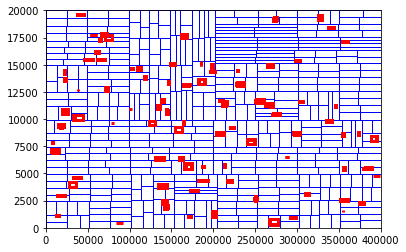

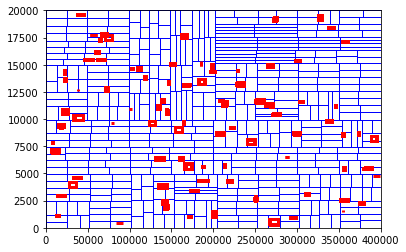

In [923]:
# for learned kdtree，
visualize_kdnodes_and_query(kdnodes, testing_set, domains_)
visualize_kdnodes_and_query(fast_kdnodes, testing_set, domains_)

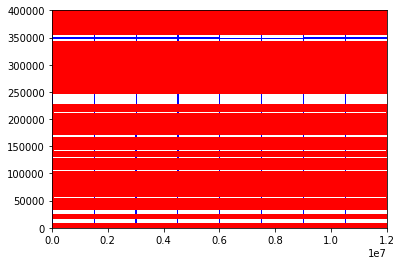

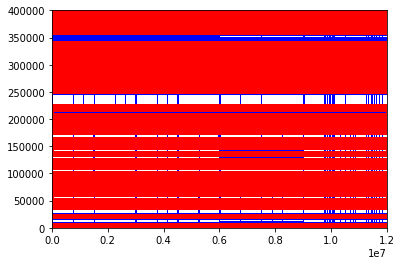

In [820]:
# for traditional kdtree
visualize_kdnodes_and_query(traditional_kdnodes, testing_set, domains_)
visualize_kdnodes_and_query(traditional_variance_kdnodes, testing_set, domains_)

In [821]:
# # === Baseline Performance 2D
# #
# # @dataset: the ordered dataset, contains only the columns to build, and ordered
# # @threshold: the block/page size
# #
# # return @minmaxnodes: contains all the min max info of all the build dimensions (in the build_dim order)
# #
# def MinMaxOrdering(dataset, threshold):
#     minmaxnodes = []
    
#     # currently sorted by A, B
#     dataset = dataset[np.lexsort((dataset[:,1], dataset[:,0]))]
    
#     count = 0;
#     total_size = len(dataset)
#     block_amount = math.ceil(total_size / threshold)
    
#     lower = 0;
#     upper = lower + threshold
    
#     # concat the results of each sorted nodes
#     for i in range(block_amount):
#         if upper > total_size:
#             upper = total_size
#         sub_dataset = dataset[lower:upper,:]
        
#         minmax_dim0 = [min(sub_dataset[:,0]),max(sub_dataset[:,0])]
#         minmax_dim1 = [min(sub_dataset[:,1]),max(sub_dataset[:,1])]
#         minmaxnodes.append([minmax_dim0, minmax_dim1])
        
#         lower += threshold
#         upper += threshold
        
#     return minmaxnodes


# def QueryMinMaxOrdering(queries, minmaxnodes):
    
#     counts = []
#     count_single_query = 0;
    
#     # number of dimensions
#     dims = int(len(queries[0]))
    
#     # for each query
#     for i in range(len(queries)):
        
#         count_single_query = 0
        
#         # check for intersection for each kdnode
#         for j in range(len(minmaxnodes)):
            
#             # for each dimension
#             intersection_tag = True
#             for k in range(dims):
                
#                 # an intersection holds if it intersecs in all dimensions
#                 if queries[i][k][0] >= minmaxnodes[j][k][1] or queries[i][k][1] <= minmaxnodes[j][k][0]:
#                     intersection_tag = False
#                     break
                
#             # if the query intersect with this kdnode
#             if intersection_tag:
#                 count_single_query += 1
            
#         counts.append(count_single_query)
    
#     #print("blocks IO: ", counts)
#     print("blocks IO(average): ", statistics.mean(counts))
    
# minmaxnodes = MinMaxOrdering(dataset, block_size)
# print('min max nodes amount: ',len(minmaxnodes))
# QueryMinMaxOrdering(testing_set, minmaxnodes)

In [822]:
# === Baseline Performance 3D
#
# @dataset: the ordered dataset, contains only the columns to build, and ordered
# @threshold: the block/page size
#
# return @minmaxnodes: contains all the min max info of all the build dimensions (in the build_dim order)
#
def MinMaxOrdering(dataset, threshold):
    minmaxnodes = []
    
    # currently sorted by A, B, C
    dataset = dataset[np.lexsort((dataset[:,2], dataset[:,1], dataset[:,0]))]
    
    count = 0;
    total_size = len(dataset)
    block_amount = math.ceil(total_size / threshold)
    
    lower = 0;
    upper = lower + threshold
    
    # concat the results of each sorted nodes
    for i in range(block_amount):
        if upper > total_size:
            upper = total_size
        sub_dataset = dataset[lower:upper,:]
        
        minmax_dim0 = [min(sub_dataset[:,0]),max(sub_dataset[:,0])]
        minmax_dim1 = [min(sub_dataset[:,1]),max(sub_dataset[:,1])]
        minmax_dim2 = [min(sub_dataset[:,2]),max(sub_dataset[:,2])]
        minmaxnodes.append([minmax_dim0, minmax_dim1, minmax_dim2])
        
        lower += threshold
        upper += threshold
        
    return minmaxnodes


def QueryMinMaxOrdering(queries, minmaxnodes):
    
    counts = []
    count_single_query = 0;
    
    # number of dimensions
    dims = int(len(queries[0]))
    
    # for each query
    for i in range(len(queries)):
        
        count_single_query = 0
        
        # check for intersection for each kdnode
        for j in range(len(minmaxnodes)):
            
            # for each dimension
            intersection_tag = True
            for k in range(dims):
                
                # an intersection holds if it intersecs in all dimensions
                if queries[i][k][0] >= minmaxnodes[j][k][1] or queries[i][k][1] <= minmaxnodes[j][k][0]:
                    intersection_tag = False
                    break
                
            # if the query intersect with this kdnode
            if intersection_tag:
                count_single_query += 1
            
        counts.append(count_single_query)
    
    #print("blocks IO: ", counts)
    print("blocks IO(average): ", statistics.mean(counts))
    
minmaxnodes = MinMaxOrdering(dataset, block_size)
print('min max nodes amount: ',len(minmaxnodes))
QueryMinMaxOrdering(testing_set, minmaxnodes)

min max nodes amount:  375
blocks IO(average):  337.84422110552765


In [823]:
# === Ignore PK ===¶
for i in range(len(testing_set)):
    testing_set[i][0][0] = domains_[0][0]
    testing_set[i][0][1] = domains_[0][1]
Query(testing_set, kdnodes)
QueryDense(testing_set, dense_kdnodes)
Query(testing_set, traditional_kdnodes)
QueryDense(testing_set, dense_traditional_kdnodes)
QueryMinMaxOrdering(testing_set, minmaxnodes)

blocks IO(average):  7.517587939698492
blocks IO(average):  9.809045226130653
blocks IO(average):  9.658291457286433
blocks IO(average):  15.864321608040202
blocks IO(average):  375


### 